#Microsoft Research Sentence Completion Challenge

In [ ]:
#importing necessary libraries 
import sys
import pandas as pd 
import csv
import os 
import random 
import collections 
import math 
import numpy as np 
import matplotlib.pyplot as plt
import nltk 
nltk.download('punkt')
from nltk import word_tokenize as tokenize 
from nltk import sent_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Obtaining the data 
Main_directory='/content/drive/MyDrive/Advanced NLP /lab2resources/lab2resources/sentence-completion'
TRAINING_DIR='/content/drive/MyDrive/Advanced NLP /lab2resources/lab2resources/sentence-completion/Holmes_Training_Data'
results_directory="/content/drive/MyDrive/Advanced NLP /ANLP assignment "

In [ ]:
#Function to split the data into training and testing 

def get_training_testing(training_dir=TRAINING_DIR,split=0.5):

    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    random.seed(53)
    random.shuffle(filenames)
    index=int(n*split)
    return(filenames[:index],filenames[index:])

trainingfiles,heldoutfiles=get_training_testing()

There are 522 files in the training directory: /content/drive/MyDrive/Advanced NLP /lab2resources/lab2resources/sentence-completion/Holmes_Training_Data


#1) N-gram Models : Unigram, Bigram, and Trigram



In [ ]:
class language_model():
    
    def __init__(self,known=2,discount=0.75,trainingdir=TRAINING_DIR,files=[]):
      self.training_dir = trainingdir
      self.files = files
      self.train()
      
    def train(self):
      self.unigram = {}
      self.bigram = {}
      self.trigram = {}

      self._processfiles()
      self._make_unknowns()
      self._discount()
      self._convert_to_probs()
    
  
    def _processline(self,line):
      #looping through the lines and getting counts of words 
      tokens = ["__START"] + tokenize(line) + ["__END"]
      previous = "__END"
      previous_trigram = ["__END", "__END"]
      for token in tokens:
        #unigrams
        self.unigram[token] = self.unigram.get(token,0) + 1
      
        #bigrams
        current_bigram = self.bigram.get(previous,{})
        current_bigram[token] = current_bigram.get(token,0) + 1
        self.bigram[previous] = current_bigram

        #trigrams
        previous_trigram[1], previous_trigram[0] = previous_trigram[0], previous_trigram[1]
        previous_trigram[1] = previous

        current_tri = self.trigram.get(tuple(previous_trigram), {})
        current_tri[token] = current_tri.get(token, 0) + 1
        self.trigram[tuple(previous_trigram)] = current_tri
        previous = token
  
    def _processfiles(self):
      #looping through the files and processing them 
      for afile in self.files:
        try:
            with open(os.path.join(self.training_dir,afile)) as instream:
                for line in instream:
                    line = line.rstrip()
                    if len(line) > 0:
                        self._processline(line)
        except UnicodeDecodeError:
            print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))
  
          
    def _convert_to_probs(self): 
      #converting word counts into probabilities   
      self.unigram = {k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
      self.bigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
      self.kn = {k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
      self.trigram = {key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.trigram.items()}
      self.kn_trigram = {k:v/sum(self.kn_tri.values()) for (k,v) in self.kn_tri.items()}
    
    
    def get_prob(self,token,context="",methodparams={}):
      #getting the probabilites of each word in the corpus 
      if methodparams.get("method","unigram") == "unigram":
        return self.unigram.get(token,self.unigram.get("__UNK",0))
    
      elif methodparams.get("method","bigram") == "bigram": 
        if methodparams.get("smoothing","kneser-ney") == "kneser-ney":
          unidist = self.kn
        else:
          unidist = self.unigram
        bigram = self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
        big_p = bigram.get(token,bigram.get("__UNK",0))
        lmbda = bigram["__DISCOUNT"]
        uni_p = unidist.get(token,unidist.get("__UNK",0))
        p = big_p + lmbda * uni_p            
        return p

      elif methodparams.get("method","trigram") == "trigram":
        if methodparams.get("smoothing","kneser-ney") == "kneser-ney":
          unidist = self.kn_trigram
          unidist_bigram = self.kn
        else:
          unidist_bigram = self.unigram

      if len(context) < 2:
        context = ["__END", context[0]]
      trigram = self.trigram.get(tuple(context[-2:]),self.trigram.get("__UNK",{}))
      trig_p = trigram.get(token,trigram.get("__UNK",0))
      lmbda_tri = trigram["__DISCOUNT"]

      bigram = self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
      big_p = bigram.get(token,bigram.get("__UNK",0))
      lmbda_bi = bigram["__DISCOUNT"]
      uni_p = unidist_bigram.get(token,unidist_bigram.get("__UNK",0))

      p = trig_p + (lmbda_tri * big_p) + (lmbda_bi * uni_p)      
      return p

    def nextlikely(self,k=1,current="",method="unigram"):
        blacklist=["__START","__DISCOUNT"]
       
        if method=="unigram":
            dist=self.unigram
        else:
            dist=self.bigram.get(current,self.bigram.get("__UNK",{}))
    
        mostlikely=list(dist.items())
        #filter out any undesirable tokens
        filtered=[(w,p) for (w,p) in mostlikely if w not in blacklist]
        #choose one randomly from the top k
        words,probdist=zip(*filtered)
        res=random.choices(words,probdist)[0]
        return res
    
    def generate(self,k=1,end="__END",limit=20,method="bigram",methodparams={}):
        if method=="":
            method=methodparams.get("method","bigram")
        current="__START"
        tokens=[]
        while current!=end and len(tokens)<limit:
            current=self.nextlikely(k=k,current=current,method=method)
            tokens.append(current)
        return " ".join(tokens[:-1])
  
    def compute_prob_line(self,line,methodparams={}):
    # Add _start to the beginning of a line of text
    # Compute the probability of the line according to the desired model
    # and returns probability together with number of tokens
    
      tokens = ["__START"] + tokenize(line) + ["__END"]
      acc = 0
      for i,token in enumerate(tokens[1:]):
          acc += math.log(self.get_prob(token,tokens[:i+1],methodparams))
      return acc,len(tokens[1:])
  
    def compute_probability(self,filenames=[],methodparams={}):
      # computes the probability (and length) of a corpus contained in filenames
      if filenames == []:
        filenames = self.files
    
      total_p = 0
      total_N = 0
      for i,afile in enumerate(filenames):
          try:
              with open(os.path.join(self.training_dir,afile)) as instream:
                  for line in instream:
                      line = line.rstrip()
                      if len(line) > 0:
                          p,N = self.compute_prob_line(line,methodparams=methodparams)
                          total_p += p
                          total_N += N
          except UnicodeDecodeError:
              print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
      return total_p,total_N
  
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
    #computing the perplexity of the models 
    # Lower perplexity means that the model better explains the data
      
      p, N = self.compute_probability(filenames=filenames,methodparams=methodparams)
      pp = math.exp(-p/N)
      
      return pp  
  
    def _make_unknowns(self,known=2):
      #accounting for unseer words in the testing set 
      unknown = 0
      self.number_unknowns = 0
      for (k,v) in list(self.unigram.items()):
        if v < known:
          del self.unigram[k]
          self.unigram["__UNK"] = self.unigram.get("__UNK",0) + v
          self.number_unknowns += 1

      for (k,adict) in list(self.bigram.items()):
        for (kk,v) in list(adict.items()):
          isknown = self.unigram.get(kk,0)
          if isknown == 0 and not kk == "__DISCOUNT":
            adict["__UNK"] = adict.get("__UNK",0) + v
            del adict[kk]
        isknown = self.unigram.get(k,0)
        if isknown == 0:
          del self.bigram[k]
          current = self.bigram.get("__UNK",{})
          current.update(adict)
          self.bigram["__UNK"] = current
        else:
          self.bigram[k] = adict

      for (k,adict) in list(self.trigram.items()):
        for (kk,v) in list(adict.items()):
          isknown = self.unigram.get(kk,0)
          if isknown == 0 and not kk == "__DISCOUNT":
            adict["__UNK"] = adict.get("__UNK",0) + v
            del adict[kk]
        previous_1, previous_2 = k
        isknown_one, isknown_two = self.unigram.get(previous_1,0), self.unigram.get(previous_2,0)
        if isknown_one == 0 or isknown_two == 0:
          del self.trigram[k]
          current = self.trigram.get("__UNK",{})
          current.update(adict)
          self.trigram["__UNK"] = current
        else:
          self.trigram[k] = adict
        
              
    def _discount(self,discount=0.75):
    # Discount each bigram count by a small fixed amount
      self.bigram = {k:{kk:value-discount for (kk,value) in adict.items()} for (k,adict) in self.bigram.items()}
    # Discount each trigram count by a small fixed amount
      self.trigram = {k:{kk:value-discount for (kk,value) in adict.items()} for (k,adict) in self.trigram.items()}
    
    # for each word, store the total amount of the discount so that the total is the same 
    # i.e., so we are reserving this as probability mass
      for k in self.bigram.keys():
          lamb = len(self.bigram[k])
          self.bigram[k]["__DISCOUNT"] = lamb * discount
              
      for k in self.trigram.keys():
          lamb = len(self.trigram[k])
          self.trigram[k]["__DISCOUNT"] = lamb * discount
    # Work out kneser-ney unigram probabilities
    # Count the number of contexts each word has been seen in
      self.kn = {}
      for (k,adict) in self.bigram.items():
        for kk in adict.keys():
          self.kn[kk] = self.kn.get(kk,0) + 1
    # knesery-ney for trigram
      self.kn_tri = {}
      for (k,adict) in self.trigram.items():
        for kk in adict.keys():
          self.kn_tri[kk] = self.kn_tri.get(kk,0) + 1

In [ ]:
class question:
  def __init__( self,aline):
    self.fields=aline
  
  def get_field(self,field):
    return self.fields[question.colnames[field]]
  
  def add_answer(self,fields):
    self.answer=fields[1]

  def get_tokens(self):
    return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]

  def get_left_context(self,window=1,target="_____"):
    found= -1
    sent_tokens= self.get_tokens()
    for i,token in enumerate(sent_tokens):
      if token== target:
        found= i 
        break
    
    if found> -1:
      return sent_tokens[i-window:i]
    else:
      return []
  
  def get_right_context(self,window=1,traget="_____"):
    found= -1
    sent_tokens= self.get_tokens()
    for i, token in enumerate(sent_tokens):
      if token== traget:
        found= i
        break
    if found > -1:
      return sent_tokens[found +1: found + window +1]
    else:
      return []

  def predict(self,lm,method=" ",smoothing="knesery-ney"):
    return self.choose(lm,method=method,smoothing=smoothing,choices=[])

  def predict_and_score(self,lm,method=" ",smoothing="kneser-ney"):
    predictions, probabilities= self.predict(lm,method=method,smoothing=smoothing)

    if predictions== self.answer:
      return 1,predictions,probabilities ####
    else:
      return 0,predictions,probabilities ####

  def choose(self,lm,method="bigram",smoothing="Kneser-ney", choices=[]):
    if choices == []:
      choices = ["a","b","c","d","e"]

    if method == "bigram":
      rc = self.get_right_context(window=1)
      lc = self.get_left_context(window=1)
      probs = [lm.get_prob(rc[0],[self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) * lm.get_prob(self.get_field(ch+")"),lc,methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]

    elif method == "trigram":
      rc = self.get_right_context(window=2)
      lc = self.get_left_context(window=2)
      probs = [lm.get_prob(self.get_field(ch+")"), lc, methodparams={"method":method.split("_")[0], "smoothing":smoothing})
              * lm.get_prob(rc[0], [lc[-1]] + [self.get_field(ch+")")],methodparams={"method":method.split("_")[0], "smoothing":smoothing})
              * lm.get_prob(rc[1], [self.get_field(ch+")")] + [rc[0]],methodparams={"method":method.split("_")[0], "smoothing":smoothing}) for ch in choices]
    
    else:
      context = self.get_left_context(window=1)
      probs = [lm.get_prob(self.get_field(ch+")"),context,methodparams={"method":method.split("_")[0]}) for ch in choices]
    
    maxprob = max(probs)
    bestchoices = [ch for ch,prob in zip(choices,probs) if prob == maxprob]

    return np.random.choice(bestchoices), probs
    

In [ ]:
class scc_reader:
    
  def __init__(self,qs,ans):
    self.qs=qs
    self.ans=ans
    self.read_files()
    
  def read_files(self):
      
    #read in the question file
    with open(self.qs) as instream:
      csvreader=csv.reader(instream)
      qlines=list(csvreader)
    
    #store the column names as a reverse index so they can be used to reference parts of the question
    question.colnames={item:i for i,item in enumerate(qlines[0])}
    
    #create a question instance for each line of the file (other than heading line)
    self.questions=[question(qline) for qline in qlines[1:]]
    
    #read in the answer file
    with open(self.ans) as instream:
      csvreader=csv.reader(instream)
      alines=list(csvreader)
        
    #add answers to questions so predictions can be checked    
    for q,aline in zip(self.questions,alines[1:]):
      q.add_answer(aline)
      
  def get_field(self,field):
    return [q.get_field(field) for q in self.questions] 
  
  def predict(self,method=" "):
    return [q.predict(method=method) for q in self.questions]
  
  def predict_and_score(self,lm,method=" ",smoothing="kneser-ney"):
    """
    Return the accuracy of the ngram, along with all its predictions and the 
    probability distribution of the options of each question
    """
    predictions = []###
    scores = []####
    probabilities=[]
    for q in self.questions:
      score, pred, p= q.predict_and_score(lm,method=method, smoothing=smoothing)
      scores.append(score)
      predictions.append(pred)
      probabilities.append(p)

    return sum(scores)/len(scores),predictions,probabilities

In [ ]:
questions_folder="/content/drive/MyDrive/Advanced NLP /lab2resources/lab2resources/sentence-completion/testing_data.csv"
answers_folder="/content/drive/MyDrive/Advanced NLP /lab2resources/lab2resources/sentence-completion/test_answer.csv"

In [ ]:
#varying the parameters of the model to obtain the best  Evaluation results
#WARNING: This cell might take up to 25 minutes to run !
number_of_files= np.linspace(20,100,3).astype(int)
known=[2,3]
predictions= []
results= []
for n in number_of_files:
  for y in known:
    random.seed(42)
    print(f'Processing {n} documents this run')
    mylm= language_model(files=trainingfiles[:n],known=y)
    SCC=scc_reader(questions_folder, answers_folder)

    #getting accuracies, predictions,probs of the three n-grams
    unigram_accuracy, unigram_predictions,unigram_p= SCC.predict_and_score(mylm,method="unigram",smoothing="kneser-ney")
    bigram_accuracy, bigram_predictions, bigram_p= SCC.predict_and_score(mylm,method="bigram",smoothing="kneser-ney")
    trigram_accuracy,trigram_predictions,trigram_p= SCC.predict_and_score(mylm,method="trigram",smoothing="kneser-ney")

    predictions.append((unigram_predictions,bigram_predictions,trigram_predictions))
    results.append((n,y,unigram_accuracy,bigram_accuracy,trigram_accuracy));

Processing 20 documents this run
Processing 20 documents this run
Processing 60 documents this run
Processing 60 documents this run
Processing 100 documents this run
UnicodeDecodeError processing HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing GHROS10.TXT: ignoring rest of file
Processing 100 documents this run
UnicodeDecodeError processing HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing GHROS10.TXT: ignoring rest of file


In [ ]:
df=pd.DataFrame(results,columns=["number of files","Unknown words","unigram accuracy","bigram accuracy","trigram accuracy"])
df

,number of files,Unknown words,unigram accuracy,bigram accuracy,trigram accuracy
0,20,2,0.251923,0.205769,0.239423
1,20,3,0.253846,0.205769,0.236538
2,60,2,0.251923,0.234615,0.256731
3,60,3,0.250000,0.234615,0.256731
4,100,2,0.243269,0.221154,0.282692
5,100,3,0.243269,0.221154,0.282692


Text(0.5, 1.0, 'Accuracy of the N-gram models')

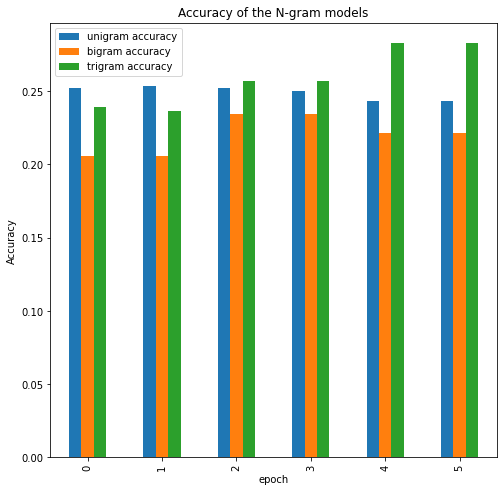

In [ ]:
df[['unigram accuracy','bigram accuracy','trigram accuracy']].plot(kind='bar',sharex=False,figsize=(8,8))
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Accuracy of the N-gram models')

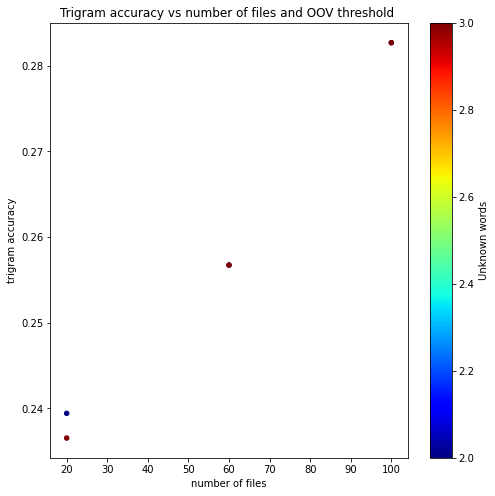

In [ ]:
df.plot(kind='scatter',x='number of files',y='trigram accuracy',c='Unknown words',cmap=plt.get_cmap('jet'),alpha=1,sharex=False,figsize=(8,8));
plt.title('Trigram accuracy vs number of files and OOV threshold ');

In [ ]:
#computing the perplexity on training and testing
#Warning: this cell might take up to 20 minutes to run 
filesets={"training":trainingfiles[:100],"testing":heldoutfiles[:100]}
methods=[{"method":"unigram"},{"method":"bigram","smoothing":"kneser-ney"},{"method":"trigram","smoothing":"kneser-ney"}]
pp_results=[]
for f,names in list(filesets.items()):
    for m in methods:

        p=mylm.compute_perplexity(filenames=names,methodparams=m)
        pp_results.append(p)
        print("Perplexity on {} with <{},{}> method is {}".format(f,m["method"],m.get("smoothing","no smoothing"),p))


UnicodeDecodeError processing file HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing file GHROS10.TXT: ignoring rest of file
Perplexity on training with <unigram,no smoothing> method is 685.4558080605616
UnicodeDecodeError processing file HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing file GHROS10.TXT: ignoring rest of file
Perplexity on training with <bigram,kneser-ney> method is 122.29939559333467
UnicodeDecodeError processing file HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing file GHROS10.TXT: ignoring rest of file
Perplexity on training with <trigram,kneser-ney> method is 34.82830760535928
UnicodeDecodeError processing file DTROY10.TXT: ignoring rest of file
UnicodeDecodeError processing file MFRND10.TXT: ignoring rest of file
Perplexity on testing with <unigram,no smoothing> method is 638.1182130919884
UnicodeDecodeError processing file DTROY10.TXT: ignoring rest of file
UnicodeDecodeError processing file MFRND10.TXT: ignoring re

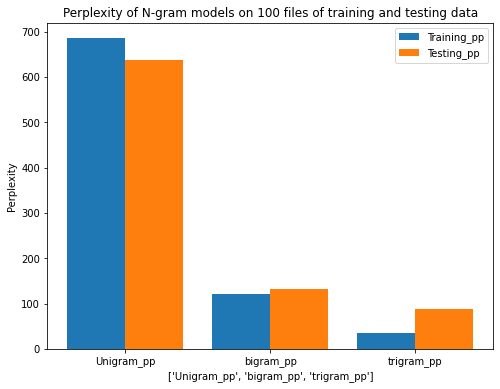

In [ ]:
#plotting Perplexity 
plt.figure(figsize=(8,6))
training_pp=pp_results[0:3]
testing_pp=pp_results[3:]
x=['Unigram_pp','bigram_pp','trigram_pp']
x_axis=np.arange(len(x))
plt.bar(x_axis-0.2,training_pp,0.4,label="Training_pp")
plt.bar(x_axis+0.2,testing_pp,0.4,label="Testing_pp")
plt.xlabel(x)
plt.xticks(x_axis, x)
plt.ylabel('Perplexity')
plt.legend()
plt.title('Perplexity of N-gram models on 100 files of training and testing data');


In [ ]:
#models outputs after hyperparmeter tuning
#Note: this cell might take up to 8 minutes to run 
mylm = language_model(known=2, discount=0.75, files=trainingfiles[:100])
SCC = scc_reader(questions_folder, answers_folder)

unigram_accuracy, unigram_predictions, unigram_probs = SCC.predict_and_score(mylm,method="unigram",smoothing='kneser-ney')
bigram_accuracy, bigram_predictions, bigram_probs = SCC.predict_and_score(mylm,method="bigram",smoothing='kneser-ney')
trigram_accuracy, trigram_predictions, trigram_probs = SCC.predict_and_score(mylm,method="trigram",smoothing='kneser-ney')


UnicodeDecodeError processing HHOHG10.TXT: ignoring rest of file
UnicodeDecodeError processing GHROS10.TXT: ignoring rest of file


In [ ]:
#saving the outputs into a csv file with parameter k=3 and files=30
with open(os.path.join(results_directory, 'MSCC_results.csv'), 'w') as out:
  writer = csv.writer(out, delimiter=',')
  writer.writerow(['num', 'unigram answers', 'bigram answers', 'trigram answers'])
  for i in range(len(unigram_predictions)):
    writer.writerow([str(i+1), unigram_predictions[i],bigram_predictions[i],trigram_predictions[i]])

In [ ]:
df_results=pd.read_csv("/content/drive/MyDrive/Advanced NLP /ANLP assignment /MSCC_results.csv")
df_results.head()

,num,unigram answers,bigram answers,trigram answers
0,1,e,e,e
1,2,e,e,e
2,3,e,e,a
3,4,c,e,c
4,5,c,c,e


In [ ]:
df_true_results=pd.read_csv("/content/drive/MyDrive/Advanced NLP /lab2resources/lab2resources/sentence-completion/test_answer.csv")
df_true_results.head()

,id,answer
0,1,c
1,2,a
2,3,d
3,4,c
4,5,d


#2) Word2Vec

In [ ]:
#importing essential libraries to run Wor2Vec Model 
import warnings
warnings.simplefilter("ignore")
import string
from scipy import spatial
import gensim 
from gensim.models import Word2Vec, KeyedVectors
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import word_tokenize, sent_tokenize 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#function to preprocess holmes data and output a list of list of words to obtain embeddings 
def preprocess_text(training_data,holmes_path,preprocessing=True):
  stop = stopwords.words('english')
  processed_data=[]
  i=1
  for file in training_data:
    try:
      text=open(os.path.join(holmes_path, file),"r")
      sentences= sent_tokenize(text.read().replace('\n',''))

      if not preprocessing:
        tokens= [sent_tokenize(sents) for sents in sentences if len(sents)>3]
      
      else:
        tokens=[[token for token in word_tokenize(sentence.lower()) if token.isalpha() and token not in stop] for sentence in sentences]
      processed_data+= tokens
      i+=1
    except UnicodeDecodeError:
      pass
  return processed_data

In [ ]:
#preprocessed holmes data 
preprocessd_holmes=preprocess_text(training_data=trainingfiles,holmes_path=TRAINING_DIR)

In [ ]:
#Loading Google News model embeddings 
google_embeddings="/content/drive/MyDrive/Advanced NLP /lab4/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin"
google_model= KeyedVectors.load_word2vec_format(google_embeddings,binary=True)

In [ ]:
#Word2Vec model with CBOW and vector size 300, window=5 and negative smapling=5, with no hierarchical softmax
holmes_model=gensim.models.word2vec.Word2Vec(sentences=preprocessd_holmes,sg=0,size=300,seed=42,hs=0,negative=5,min_count=5,window=5)

In [ ]:
def get_vector_embs(words, google_embeddings, holmes_embeddings, google_embs=True, holmes_embs=False):
  #getting the embeddings for ech word for each method 
  dimension= google_embeddings['hello'].size
  vect_rep= []
  for word in words:
    if google_embs and word in google_embeddings:
      vect_rep.append(google_embeddings[word])

    elif holmes_embs and word in holmes_embeddings:
      vect_rep.append(holmes_embeddings[word])

    else: # if the word is not in holmes and google generate a 300 size random vector
      vect_rep.append(np.random.uniform(-1,1,dimension))

  return vect_rep

#computing the similarity using cos similarity
def similarity(vector, question_vector):
  sim= 0
  for v_q in question_vector:
    cos_similarity = 1 - spatial.distance.cosine(vector, v_q)

    sim+= cos_similarity

  return sim
#computing the average  similarity
def average_sim(possible_vector, vectors):

  embeddings_sum= 0
  for v in vectors:
    embeddings_sum+= v

  avg_sentence_embs= embeddings_sum/ len(vectors)
  
  result= 1 - spatial.distance.cosine(avg_sentence_embs, possible_vector)

  return result

#funtion to evaluate the Word2Vec Models
def Word2Vec_preds(embeddings_one, embeddings_two, google, holmes,avg_similarity=False):
  gross_scores = []
  with open(answers_folder) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)

  questions_df=pd.DataFrame(lines[1:],columns=lines[0])
  answers=np.array(questions_df['answer'])

  tags=['a)', 'b)', 'c)', 'd)', 'e)']
  choices=['a', 'b', 'c', 'd', 'e']
  preds=[]

  with open(questions_folder) as qf:
    csvreader=csv.reader(qf)
    lines=list(csvreader)

  questions_df=pd.DataFrame(lines[1:],columns=lines[0])
  questions=list(questions_df['question'])

  for i,quest in enumerate(questions):
    tokens=tokenize(quest)
    # Get question embeddings
    ques_vector=get_vector_embs(tokens, embeddings_one, embeddings_two, google, holmes)
    scores=[]
    possible_choice=[questions_df[t][i] for t in tags]

    # Get candidate word embeddings
    possible_vector= get_vector_embs(possible_choice, embeddings_one, embeddings_two, google, holmes)

    # Calculate total word similarity
    for word in possible_vector:
      if not avg_similarity:
        sim=similarity(word, ques_vector)
      else:
        sim=average_sim(word, ques_vector)    

      scores.append(sim)
    
    Index=scores.index(max(scores))
    ans= choices[Index]
    preds.append(ans)

    gross_scores.append(scores)

    accuracy=np.sum(preds==np.array(answers))/len(preds)*100

  return np.array(preds),accuracy,gross_scores

In [ ]:
#getting the Evaluation results for both Word2Vec Models
Word2Vec_results=[]
Word2Vec_preds_scores=[]
Holmes=[False,True]
Google=[True,False]
avg_sim=[False,True]
for google in Google:
  for holmes in Holmes:
    if not google and not holmes:
      continue
    for sim in avg_sim:
      predictions,accuracy,scores= Word2Vec_preds(google_model,holmes_model,google,holmes,avg_similarity=sim)
      Word2Vec_results.append((holmes,google,sim,accuracy))
      Word2Vec_preds_scores.append((predictions,scores));

In [ ]:
Word2Vec_df=pd.DataFrame(Word2Vec_results,columns=['Holmes_Model','Google_Model','Average_total_similarity','Word2Vec accuracy'])
Word2Vec_df

,Holmes_Model,Google_Model,Average_total_similarity,Word2Vec accuracy
0,False,True,False,34.903846
1,False,True,True,30.865385
2,True,True,False,34.711538
3,True,True,True,32.403846
4,True,False,False,41.442308
5,True,False,True,42.115385


In [ ]:
w2v_predictions_holmes , w2v_scores_holmes= Word2Vec_preds_scores[5]
w2v_predictions_google, w2v_scores_google= Word2Vec_preds_scores[0]

df = pd.read_csv(os.path.join(results_directory, 'MSCC_results.csv'), delimiter=',')

df['answer Word2Vec_Holmes']=w2v_predictions_holmes
df['answer Word2Vec_Google']=w2v_predictions_google

df.to_csv(os.path.join(results_directory, 'MSCC results.csv'), sep=',', index=False)

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Advanced NLP /ANLP assignment /MSCC results.csv')
df.head()

,num,unigram answers,bigram answers,trigram answers,answer Word2Vec_Holmes,answer Word2Vec_Google
0,1,e,e,e,c,a
1,2,e,e,e,a,e
2,3,e,e,a,c,d
3,4,c,e,c,b,c
4,5,c,c,e,d,d


In [ ]:
predictions_unigram, predictions_bigram, predictions_trigram,predictions_w2v_Holmes, predictions_w2v_Google = df['unigram answers'], df['bigram answers'], df['trigram answers'],df['answer Word2Vec_Holmes'], df['answer Word2Vec_Google']

In [ ]:
#function to get the models' accuracies 
def model_accuracy(preds):
  with open(answers_folder) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
  
  answers_df=pd.DataFrame(lines[1:],columns=lines[0])
  answers=np.array(answers_df['answer'])

  return np.sum(preds== answers)/ len(answers)

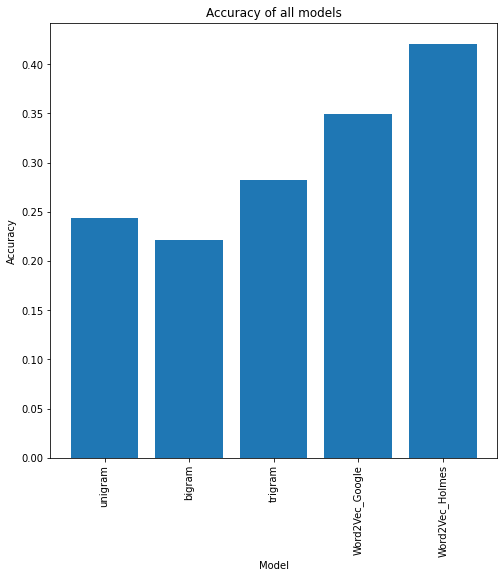

In [ ]:
#bar plot of models' accuracies
unigram_acc= model_accuracy(predictions_unigram)
bigram_acc= model_accuracy(predictions_bigram)
trigram_acc= model_accuracy(predictions_trigram)
w2v_Google_accuracy= model_accuracy(predictions_w2v_Google)
w2v_Holmes_accuracy=model_accuracy(predictions_w2v_Holmes)

plt.figure(figsize=(8,8))
plt.bar(['unigram', 'bigram', 'trigram', 'Word2Vec_Google','Word2Vec_Holmes'], [unigram_acc, bigram_acc, trigram_acc, w2v_Google_accuracy,w2v_Holmes_accuracy])
plt.title('Accuracy of all models')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Accuracy');


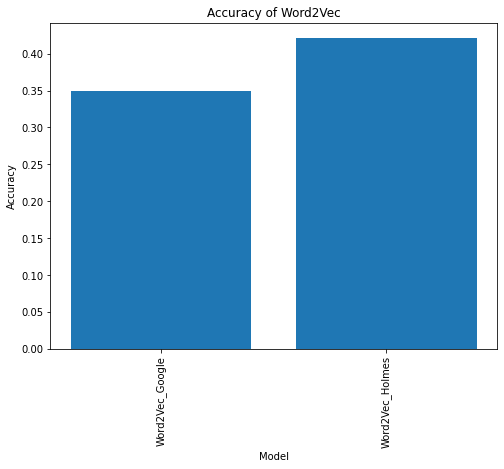

In [ ]:
#plot of Wor2Vec moles' accuracies 
plt.figure(figsize=(8,6))
plt.bar(['Word2Vec_Google','Word2Vec_Holmes'], [ w2v_Google_accuracy,w2v_Holmes_accuracy])
plt.title('Accuracy of Word2Vec')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Accuracy');

In [ ]:
#function to compare models predictions 
def predictions_comparisions(preds1, preds2):

  with open(answers_folder) as instream:
    csvreader = csv.reader(instream)
    lines = list(csvreader)

  answers_df = pd.DataFrame(lines[1:],columns=lines[0])
  answers = np.array(answers_df['answer'])
  
  shared_right_ans= np.array([1 if answers[i] == preds1[i] and preds1[i] == preds2[i] else 0 for i in range(len(preds1))])
  shared_wrong_ans= np.array([1 if answers[i] != preds1[i] and preds1[i] == preds2[i] else 0 for i in range(len(preds1))])

  return  np.sum(shared_right_ans) / len(preds1) * 100, np.sum(shared_wrong_ans) / len(preds1) * 100

In [ ]:
#comparing models predictions
tri_uni_shared_right, tri_uni_shared_wrong= predictions_comparisions(predictions_trigram, predictions_unigram)
tri_bi_shared_right, tri_bi_shared_wrong= predictions_comparisions(predictions_trigram, predictions_bigram)
w2v_holmes_uni_shared_right, w2v_holmes_uni_shared_wrong= predictions_comparisions(predictions_w2v_Holmes, predictions_unigram)
w2v_holmes_bi_shared_right, w2v_holmes_bi_shared_wrong= predictions_comparisions(predictions_w2v_Holmes, predictions_bigram)
w2v_holmes_tri_shared_right, w2v_holmes_tri_shared_wrong= predictions_comparisions(predictions_w2v_Holmes, predictions_trigram)
w2v_google_uni_shared_right, w2v_google_uni_shared_wrong= predictions_comparisions(predictions_w2v_Google, predictions_unigram)
w2v_google_bi_shared_right, w2v_google_bi_shared_wrong= predictions_comparisions(predictions_w2v_Google, predictions_bigram)
W2v_google_tri_shared_right, w2v_google_tri_shared_wrong=predictions_comparisions(predictions_w2v_Google,predictions_trigram)

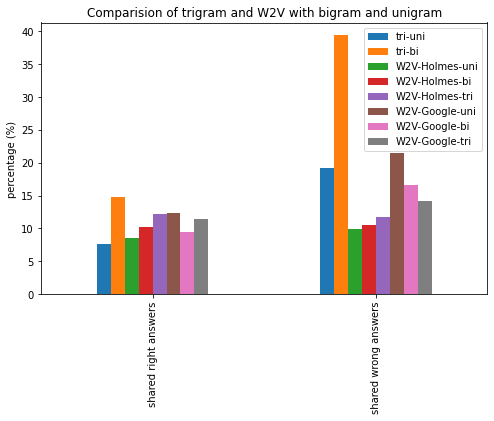

In [ ]:
#plotting models predictions
titles= ['shared right answers', 'shared wrong answers']
shared_right_answers= [tri_uni_shared_right, tri_bi_shared_right, w2v_holmes_uni_shared_right, w2v_holmes_bi_shared_right, w2v_holmes_tri_shared_right,w2v_google_uni_shared_right,w2v_google_bi_shared_right,W2v_google_tri_shared_right]
shared_wrong_answers= [tri_uni_shared_wrong, tri_bi_shared_wrong, w2v_holmes_uni_shared_wrong, w2v_holmes_bi_shared_wrong, w2v_holmes_tri_shared_wrong,w2v_google_uni_shared_wrong,w2v_google_bi_shared_wrong, w2v_google_tri_shared_wrong]

labels = ['tri-uni','tri-bi','W2V-Holmes-uni','W2V-Holmes-bi','W2V-Holmes-tri','W2V-Google-uni','W2V-Google-bi','W2V-Google-tri']

df = pd.DataFrame((shared_right_answers,shared_wrong_answers),index=titles, columns=labels)
ax = df.plot(kind='bar', figsize=(8,5))
ax.set_ylabel('percentage (%)')
ax.set_title("Comparision of trigram and W2V with bigram and unigram");